In [1]:
# Google Colab Only
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia
except Exception:
    pass

%pip install -q tabulate

/dataeval/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
from collections.abc import Sequence
from typing import cast

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from maite_datasets.image_classification import MNIST
from tabulate import tabulate
from torch.utils.data import DataLoader, Dataset, Subset

from dataeval.workflows import Sufficiency

np.random.seed(0)
np.set_printoptions(formatter={"float": lambda x: f"{x:0.4f}"})
torch.manual_seed(0)
torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True

random.seed(0)
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
# Configure the dataset transforms
transforms = [
    lambda x: x / 255.0,  # scale to [0, 1]
    lambda x: x.astype(np.float32),  # convert to float32
]

# Download the mnist dataset and apply the transforms and subset the data
train_ds = Subset(MNIST(root="./data", image_set="train", transforms=transforms), range(2500))
test_ds = Subset(MNIST(root="./data", image_set="test", transforms=transforms), range(500))

In [4]:
# Define our network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Compile the model
model = torch.compile(Net().to(device))

# Type cast the model back to Net as torch.compile returns a Unknown
# Nothing internally changes from the cast; we are simply signaling the type
model = cast(Net, model)

In [5]:
def custom_train(model: nn.Module, dataset: Dataset, indices: Sequence[int]):
    # Defined only for this testing scenario
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epochs = 10

    # Define the dataloader for training
    dataloader = DataLoader(Subset(dataset, indices), batch_size=16)

    for epoch in range(epochs):
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load one-hot encoded targets/labels to device
            y = torch.argmax(torch.asarray(batch[1], dtype=torch.int).to(device), dim=1)
            # Zero out gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(X)
            # Compute loss
            loss = criterion(outputs, y)
            # Back prop
            loss.backward()
            # Update weights/parameters
            optimizer.step()

In [6]:
def custom_eval(model: nn.Module, dataset: Dataset) -> dict[str, float]:
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    result = 0

    # Set model layers into evaluation mode
    model.eval()
    dataloader = DataLoader(dataset, batch_size=16)
    # Tell PyTorch to not track gradients, greatly speeds up processing
    with torch.no_grad():
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load one-hot encoded targets/labels to device
            y = torch.argmax(torch.asarray(batch[1], dtype=torch.int).to(device), dim=1)
            preds = model(X)
            metric.update(preds, y)
        result = metric.compute().cpu()
    return {"Accuracy": result}

In [7]:
# Instantiate sufficiency metric
suff = Sufficiency(
    model=model,
    train_ds=train_ds,
    test_ds=test_ds,
    train_fn=custom_train,
    eval_fn=custom_eval,
    runs=5,
    substeps=10,
)

In [8]:
# Train & test model
output = suff.evaluate()

W0702 18:16:21.331000 1657 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


In [9]:
# Print out sufficiency output in a table format
formatted = {"Steps": output.steps, **output.averaged_measures}
print(tabulate(formatted, headers=list(formatted), tablefmt="pretty"))

+-------+---------------------+
| Steps |      Accuracy       |
+-------+---------------------+
|  25   | 0.09560000151395798 |
|  41   | 0.40160000026226045 |
|  69   | 0.6236000061035156  |
|  116  | 0.7168000102043152  |
|  193  | 0.7799999952316284  |
|  322  | 0.8336000084877014  |
|  538  | 0.8727999925613403  |
|  898  | 0.9075999975204467  |
| 1498  | 0.9236000061035157  |
| 2500  | 0.9456000089645386  |
+-------+---------------------+


In [10]:
# Print out projected output values
projection = output.project([1000, 2500, 5000])
projected = {"Steps": projection.steps, **projection.averaged_measures}
print(tabulate(projected, list(projected), tablefmt="pretty"))

+-------+--------------------+
| Steps |      Accuracy      |
+-------+--------------------+
| 1000  | 0.9076590430021647 |
| 2500  | 0.9261227080701462 |
| 5000  | 0.9329675224776066 |
+-------+--------------------+


In [11]:
### TEST ASSERTION CELL ###
assert -0.02 < output.averaged_measures["Accuracy"][-1] - projection.averaged_measures["Accuracy"][-2] < 0.02

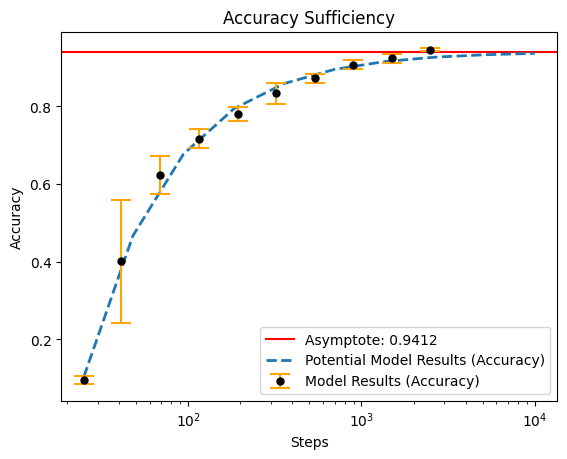

In [12]:
# Plot the output using the convenience function
_ = output.plot(error_bars=True, asymptote=True)

In [13]:
# Initialize the array of desired accuracies
desired_accuracies = np.array([0.90, 0.93, 0.99])

# Evaluate the learning curve to infer the needed amount of training data
samples_needed = output.inv_project({"Accuracy": desired_accuracies})

/dataeval/src/dataeval/outputs/_workflows.py:148: UserWarning: Number of samples could not be determined for target(s): [0.99]
  warnings.warn(


In [14]:
# Print the amount of needed data needed to achieve the accuracies of interest
for i, accuracy in enumerate(desired_accuracies):
    print(f"To achieve {int(accuracy * 100)}% accuracy, {int(samples_needed['Accuracy'][i])} samples are needed.")

To achieve 90% accuracy, 789 samples are needed.
To achieve 93% accuracy, 3514 samples are needed.
To achieve 99% accuracy, -1 samples are needed.
